# ChEMBL - Fetch Raw Data - *P. falciparum*

**Date:** 16/01/23

**Based on:** [TeachOpenCADD T001 - Compound data acquisition (ChEMBL)](https://projects.volkamerlab.org/teachopencadd/talktorials/T001_query_chembl.html)

**Done by:** Gustavo H. M. Sousa

Session information at the end of the notebook.

## Retrieving ChEMBL biological data of the target DHFR - *Plasmodium*

### Importing, defining paths and specifying query parameters

The [ChEMBL database](https://www.ebi.ac.uk/chembl/) can be defined as “a manually curated database of bioactive molecules with drug-like properties. It brings together chemical, bioactivity and genomic data to aid the translation of genomic information into effective new drugs.”
I'm going to use its API (Application Programming Interface) to gather some raw data so we can do some modeling afterwards. The first thing we're going to do is to import some libraries:

In [1]:
import math
from pathlib import Path
from zipfile import ZipFile
from tempfile import TemporaryDirectory

import numpy as np
import pandas as pd
from rdkit.Chem import PandasTools
from chembl_webresource_client.new_client import new_client # This is the API chembl library
from tqdm.auto import tqdm

We can use the `Path` library to define our relative or absolute directory path to save our files.

In [2]:
HERE = Path(_dh[-1])
DATA = HERE / "data"
# We are defining the relative path so we can store the data retrieved
DATA

PosixPath('/home/gustavo/github/masters/datasets/raw/data')

Next, we can specify the parameters of our API query. This is done assigning objects using the `new_client` and then the suffix after the '.' to the specifc parameters.

In [3]:
targets_api = new_client.target
compounds_api = new_client.molecule
bioactivities_api = new_client.activity

type(targets_api)

chembl_webresource_client.query_set.QuerySet

### Target information

We now specify the UniProt ID of our target, in our case we're going to start with the following:
* **UniProt ID:** P13922
* **Entry name:** DRTS_PLAFK
* **Organism:** *Plasmodium falciparum* (isolate K1 / Thailand)
* **Length:** 608 AA

In [4]:
uniprot_id = "P13922"

Then **fetch** the data for this UniProt ID

In [5]:
targets = targets_api.get(target_components__accession=uniprot_id).only(
    "target_chembl_id", "organism", "pref_name", "target_type"
)
print(type(targets))

<class 'chembl_webresource_client.query_set.QuerySet'>


The results of the query are stored in targets, a QuerySet, i.e. the results are not fetched from ChEMBL until we ask for it (here using pandas.DataFrame.from_records). This is called QuerySets and they are 'lazy'.

In [6]:
targets = pd.DataFrame.from_records(targets)
targets

,organism,pref_name,target_chembl_id,target_type
0,Plasmodium falciparum K1,Dihydrofolate reductase,CHEMBL1939,SINGLE PROTEIN
1,Plasmodium falciparum K1,Dihydrofolate reductase,CHEMBL1939,SINGLE PROTEIN


After inspecting ou dataframe with the *'organism'*, *'pref_name'* and *'target_chembl_id'* and *'target_type'*, we can select what row are of interest. In our case, the rows are both the same (I don't know exactly why?) so we can select either.

In [7]:
# We transform ou variable targets, previously a datafram into a pandas' series
targets = targets.iloc[0]
targets

organism            Plasmodium falciparum K1
pref_name            Dihydrofolate reductase
target_chembl_id                  CHEMBL1939
target_type                   SINGLE PROTEIN
Name: 0, dtype: object

Saving the 'target_chembl_id': 

In [8]:
chembl_id = targets.target_chembl_id
print(chembl_id)

CHEMBL1939


### Fetching biological data to our target

Now we can finally fetch the biological data for our target, taking the following into consideration:
* bioactivity type `Ki` (there are more information about in our case)
* exact measurements (relation `=`)
* binding data (assay type `B`)

In [9]:
bioacitivies_plasmodium = bioactivities_api.filter(
    target_chembl_id=chembl_id, type='Ki', relation='=', assay_type="B"
).only(
    "activity_id",
    "assay_chembl_id",
    "assay_description",
    "assay_type",
    "molecule_chembl_id",
    "type",
    "standard_units",
    "relation",
    "standard_value",
    "target_chembl_id",
    "target_organism",
)

print(f"The total size of the biological activities fetched is: {len(bioacitivies_plasmodium)} of type, {type(bioacitivies_plasmodium)}")

The total size of the biological activities fetched is: 716 of type, <class 'chembl_webresource_client.query_set.QuerySet'>


For example, each element of our `bioactivities_plasmodium` object, (that is basically a dictionary) contains the following:

In [10]:
print(f"{bioacitivies_plasmodium[0]}")

{'activity_id': 185071, 'assay_chembl_id': 'CHEMBL811761', 'assay_description': 'Binding affinity was evaluated as inhibition of recombinant wild type (WT) Plasmodium falciparum DHFR-TS.', 'assay_type': 'B', 'molecule_chembl_id': 'CHEMBL2364573', 'relation': '=', 'standard_units': 'nM', 'standard_value': '4.7', 'target_chembl_id': 'CHEMBL1939', 'target_organism': 'Plasmodium falciparum K1', 'type': 'Ki', 'units': 'nM', 'value': '4.7'}


We can now finally download the *dataset* containing only `Ki` and exact measurements for our target.

In [11]:
bioactivities_plasmodium_df = pd.DataFrame.from_records(bioacitivies_plasmodium)
print(f"The dataframe shape is: {bioactivities_plasmodium_df.shape}")
bioactivities_plasmodium_df.head(10)

The dataframe shape is: (717, 13)


,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,units,value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
1,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,4.7
2,185072,CHEMBL811759,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,14.5,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,14.5
3,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,3.1
4,187527,CHEMBL668412,Inhibitory activity against double mutant dihy...,B,CHEMBL324775,=,nM,103.5,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,103.5
5,187529,CHEMBL668414,Inhibitory activity against triple mutant dihy...,B,CHEMBL324775,=,nM,292.4,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,292.4
6,187531,CHEMBL668413,Inhibitory activity against quadruple mutant d...,B,CHEMBL324775,=,nM,445.1,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,445.1
7,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,0.4
8,188711,CHEMBL668412,Inhibitory activity against double mutant dihy...,B,CHEMBL416373,=,nM,5.6,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,5.6
9,188713,CHEMBL668414,Inhibitory activity against triple mutant dihy...,B,CHEMBL416373,=,nM,105.6,CHEMBL1939,Plasmodium falciparum K1,Ki,nM,105.6


We can do a first estimation of unique structures in our dataset. For *Plasmodium falciparum* type K1 we have almost 150 structures. It is possible that after the processing of our data we end up with way less than this, but this is a decent estimation.

In [12]:
# Just an estimation of our unique values:
print(bioactivities_plasmodium_df["molecule_chembl_id"].unique().shape[0])

145


In [13]:
bioactivities_plasmodium_df["units"].unique()

array(['nM', 'uM'], dtype=object)

Note also that we have columns for `standard_units/units` and `standard_values/values`; in the following, we will use the standardized columns (standardization by ChEMBL), and thus, we drop the other two columns.

In [14]:
bioactivities_plasmodium_df.drop(["units", "value"], axis=1, inplace=True)
bioactivities_plasmodium_df.head()

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
1,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki
2,185072,CHEMBL811759,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,14.5,CHEMBL1939,Plasmodium falciparum K1,Ki
3,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki
4,187527,CHEMBL668412,Inhibitory activity against double mutant dihy...,B,CHEMBL324775,=,nM,103.5,CHEMBL1939,Plasmodium falciparum K1,Ki


### Divergent: only wild-type assays


We're going to try and process one-way only the wild-type for now:

In [15]:
only_wildtype = bioactivities_plasmodium_df[~bioactivities_plasmodium_df['assay_description'].str.contains('utant', regex=False, case=False)].reset_index(drop=True)

# Changing the variable type to float
only_wildtype = only_wildtype.astype({'standard_value':'float64'})

# Dropping NA values
only_wildtype.dropna(axis=0, how="any", inplace=True)

In [16]:
# The mean of the values
only_wildtype_mean = only_wildtype[['molecule_chembl_id', 'standard_value']].groupby('molecule_chembl_id').mean().reset_index()
only_wildtype_mean = only_wildtype_mean.rename(columns={'standard_value':'mean_standard_value'})
only_wildtype_mean.head(3)
print(only_wildtype_mean.shape[0])

,molecule_chembl_id,mean_standard_value
0,CHEMBL115483,2.0
1,CHEMBL118202,2.3
2,CHEMBL118425,7.0


In [17]:
only_wildtype.drop_duplicates('molecule_chembl_id', keep='first', inplace=True)
only_wildtype_merged = pd.merge(only_wildtype, only_wildtype_mean, how='left', on='molecule_chembl_id')
only_wildtype_merged.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,mean_standard_value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,4.7
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,3.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,0.4


### Preprocess the data

For the pre-processing of the data we're going to do the following:

1. Convert the `standard_value` type from `object` to `float`.
2. Delete entries with missing values (I think in our case there is none)
3. Keep only nanomolar entries or convert `uM` to `nM` by applying a x1000 multiplication factor
4. Delete duplicate molecules - **That is a questionable step we could take the mean of the two**
5. Reset the `DataFrame` index
6. Rename columns

The field `standard_value` holds `Ki` values. We're going to perform some calculations later on and we need to convert them from `objects` to `float`.

This is an important step, specially when dealing with a lot of information and **you should always check each variable type** prior of doing any calculation! This is just basic data analysis good practices.

#### 1. Convert `starndard_value` type

In [18]:
bioactivities_plasmodium_df.dtypes

activity_id            int64
assay_chembl_id       object
assay_description     object
assay_type            object
molecule_chembl_id    object
relation              object
standard_units        object
standard_value        object
target_chembl_id      object
target_organism       object
type                  object
dtype: object

In [19]:
bioactivities_plasmodium_df = bioactivities_plasmodium_df.astype({'standard_value': "float64"})
bioactivities_plasmodium_df.dtypes

activity_id             int64
assay_chembl_id        object
assay_description      object
assay_type             object
molecule_chembl_id     object
relation               object
standard_units         object
standard_value        float64
target_chembl_id       object
target_organism        object
type                   object
dtype: object

#### 2. Delete entries with missing values 

In [20]:
# We can use the parameter `inplace = True` to do the changes into the dataframe directly
bioactivities_plasmodium_df.dropna(axis=0, how="any", inplace=True)
print(f"The shape after dropping NA values: {bioactivities_plasmodium_df.shape}")

The shape after dropping NA values: (717, 11)


So we basically do not have any NA values!

#### 3. Keep only entries with “standard_unit == nM”

In [21]:
print(f"{bioactivities_plasmodium_df['standard_units'].unique()}")

# Number of entries with standard_units columns != nM

print(f"Number of non nM entries: {bioactivities_plasmodium_df[bioactivities_plasmodium_df['standard_units'] != 'nM'].shape[0]}")

['nM']
Number of non nM entries: 0


#### 4. Delete or group by mean duplicated molecules

Sometimes the same molecule (molecule_chembl_id) has been tested more than once, in this case, we only keep the first one or even keep the mean of the measurements. We're gonna do the mean of the measurements and also just keep the first as it is on the tutorial.

In [22]:
# If we wanted to delete the duplicates and only keep the first one we would do:
# bioactivities_plasmodium_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
# print(f"DataFrame shape: {bioactivities_plasmodium_df.shape}")

# But if we'd want to keep the mean we can do:
bioactivites_mean_df=bioactivities_plasmodium_df[["molecule_chembl_id","standard_value"]].groupby('molecule_chembl_id').mean().reset_index()
bioactivites_mean_df.rename(columns={"standard_value": "mean_standard_value"}, inplace=True)
bioactivites_mean_df


,molecule_chembl_id,mean_standard_value
0,CHEMBL115483,225.450000
1,CHEMBL118202,325.075000
2,CHEMBL118425,491.825000
3,CHEMBL118581,500.425000
4,CHEMBL118602,1133.450000
...,...,...
140,CHEMBL95609,59471.428571
141,CHEMBL95615,9701.428571
142,CHEMBL95725,13200.000000
143,CHEMBL95783,18828.571429


In [23]:

bioactivities_last = bioactivities_plasmodium_df[['molecule_chembl_id', 'standard_value']]
bioactivities_last.drop_duplicates('molecule_chembl_id', keep='last', inplace=True)
bioactivities_last.rename(columns={"standard_value": "last_standard_value"}, inplace=True)
bioactivities_last

/tmp/ipykernel_16803/3494885800.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_last.drop_duplicates('molecule_chembl_id', keep='last', inplace=True)
/tmp/ipykernel_16803/3494885800.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  bioactivities_last.rename(columns={"standard_value": "last_standard_value"}, inplace=True)


,molecule_chembl_id,last_standard_value
2,CHEMBL2364573,14.5
6,CHEMBL324775,445.1
14,CHEMBL291931,1129.6
18,CHEMBL119188,770.1
27,CHEMBL30937,1380.0
...,...,...
712,CHEMBL95615,410.0
713,CHEMBL365894,930.0
714,CHEMBL95609,800.0
715,CHEMBL95274,1500.0


We can basically drop the duplicates by keeping only the first value, as it is taught in the tutorial but I'm going to keep both the first entries and the mean just in case.

In [24]:
bioactivities_plasmodium_df.drop_duplicates("molecule_chembl_id", keep="first", inplace=True)
print(bioactivities_plasmodium_df.shape[0])

145


We can then merge the two datasets by keeping also the mean using the `pd.merge` pandas function using `molecule_chembl_id` as our key:

In [25]:
merged_bioactivities_plasmodium = pd.merge(bioactivities_plasmodium_df, bioactivites_mean_df, how="left", on="molecule_chembl_id")
merged_bioactivities_plasmodium = pd.merge(merged_bioactivities_plasmodium, bioactivities_last, how="left", on="molecule_chembl_id")

merged_bioactivities_plasmodium

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,mean_standard_value,last_standard_value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,7.966667,14.5
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,211.025000,445.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,53.985714,5.6
3,189896,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL291931,=,nM,7.2,CHEMBL1939,Plasmodium falciparum K1,Ki,477.500000,1129.6
4,189912,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL119188,=,nM,0.6,CHEMBL1939,Plasmodium falciparum K1,Ki,246.200000,770.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
140,1136399,CHEMBL821377,Binding affinity towards wild-type dihydrofola...,B,CHEMBL161673,=,nM,0.6,CHEMBL1939,Plasmodium falciparum K1,Ki,215.580000,955.0
141,1137686,CHEMBL821377,Binding affinity towards wild-type dihydrofola...,B,CHEMBL161034,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,80.100000,3.8
142,1464744,CHEMBL828776,Inhibition constant against Plasmodium falcipa...,B,CHEMBL129788,=,nM,1.1,CHEMBL1939,Plasmodium falciparum K1,Ki,1.100000,1.1
143,1464745,CHEMBL828776,Inhibition constant against Plasmodium falcipa...,B,CHEMBL185800,=,nM,180.0,CHEMBL1939,Plasmodium falciparum K1,Ki,180.000000,180.0


#### 5. Reseting the DF index

Reseting the dataframe index, just in case any index came out of place.

In [26]:
merged_bioactivities_plasmodium.reset_index(inplace=True, drop=True)
merged_bioactivities_plasmodium.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,standard_value,target_chembl_id,target_organism,type,mean_standard_value,last_standard_value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,7.966667,14.5
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,211.025000,445.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,53.985714,5.6


#### 6. Renaming and reordering the columns

In [27]:
merged_bioactivities_plasmodium.rename(columns={'standard_value': 'first_Ki_value', 'mean_standard_value': 'mean_Ki_value', 'last_standard_value': 'last_Ki_value'}, inplace=True)
merged_bioactivities_plasmodium.head(3)

,activity_id,assay_chembl_id,assay_description,assay_type,molecule_chembl_id,relation,standard_units,first_Ki_value,target_chembl_id,target_organism,type,mean_Ki_value,last_Ki_value
0,185071,CHEMBL811761,Binding affinity was evaluated as inhibition o...,B,CHEMBL2364573,=,nM,4.7,CHEMBL1939,Plasmodium falciparum K1,Ki,7.966667,14.5
1,187525,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL324775,=,nM,3.1,CHEMBL1939,Plasmodium falciparum K1,Ki,211.025000,445.1
2,188709,CHEMBL821379,Inhibitory activity against wild-type dihydrof...,B,CHEMBL416373,=,nM,0.4,CHEMBL1939,Plasmodium falciparum K1,Ki,53.985714,5.6


In [28]:
merged_bioactivities_plasmodium = merged_bioactivities_plasmodium[['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type', 'molecule_chembl_id', 'relation', 'first_Ki_value','last_Ki_value', 'mean_Ki_value', 'standard_units', 'standard_units', 'target_chembl_id', 'target_organism']]

In [29]:
result = merged_bioactivities_plasmodium.shape[0]
print(result)

145


    So we finally have {{result}} molecules ids with their respective biological activity.

### Download the compound data from ChEMBL

We can finally download the compound data from the ChEMBL database, again using the API from the site.

In [30]:
compounds_provider = compounds_api.filter(
    molecule_chembl_id__in=list(merged_bioactivities_plasmodium['molecule_chembl_id'])
).only('molecule_chembl_id', 'molecule_structures')

In [31]:
compounds = list(tqdm(compounds_provider))

  0%|          | 0/145 [00:00<?, ?it/s]

After waiting for the compounds to be gathered (using the list function I think), we can now take a peek in our SMILES strucutres gathered.

In [32]:
compounds_df = pd.DataFrame.from_records(compounds)
print(compounds_df.shape)
compounds_df.head(5)

(145, 2)


,molecule_chembl_id,molecule_structures
0,CHEMBL7004,{'canonical_smiles': 'Cc1ccc(N2C(N)=NC(N)=NC2(...
1,CHEMBL7005,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
2,CHEMBL6741,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
3,CHEMBL6742,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
4,CHEMBL22,{'canonical_smiles': 'COc1cc(Cc2cnc(N)nc2N)cc(...


We can perform now the following steps:
1. Remove entries with missing structures
2. Delete duplicate molecule by `'molecule_chembl_id'` variable
3. Get only molecules with **Canonical SMILES**

#### 1. Remove missing structures

In [33]:
compounds_df.dropna(axis=0, how="any", inplace=True)
print(compounds_df.shape[0])

compounds_df.head(3)

145


,molecule_chembl_id,molecule_structures
0,CHEMBL7004,{'canonical_smiles': 'Cc1ccc(N2C(N)=NC(N)=NC2(...
1,CHEMBL7005,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...
2,CHEMBL6741,{'canonical_smiles': 'CC1(C)N=C(N)N=C(N)N1c1cc...


Ok, so no missing entries. Nice!

#### 2. Delete duplicates

In [34]:
compounds_df.drop_duplicates('molecule_chembl_id', keep='first', inplace=True)
print(compounds_df.shape[0])

145


No duplicates! Nice!

#### 3. Only Canonical SMILES

As one can see, we have multiple outputs for the structure gathered in `compounds_df`, but we only want to keep the canonical_smiles information.

In [35]:
compounds_df.iloc[0].molecule_structures.keys()

dict_keys(['canonical_smiles', 'molfile', 'standard_inchi', 'standard_inchi_key'])

We can do a `for` loop to retrieve only the canonical_smiles key. That's what we do below:

In [36]:
canonical_smiles = []

for i, compounds in compounds_df.iterrows():
    try:
        canonical_smiles.append(compounds["molecule_structures"]["canonical_smiles"])
    except KeyError:
        canonical_smiles.append(None)

compounds_df['smiles'] = canonical_smiles
compounds_df.drop('molecule_structures', axis=1, inplace=True)


Sanity check to see if there is any NA value appended before.

In [37]:
compounds_df.dropna(axis=0, how='any', inplace=True)
print(f"The shape of the compounds dataset is: {compounds_df.shape}")
compounds_df.head(3)

The shape of the compounds dataset is: (145, 2)


,molecule_chembl_id,smiles
0,CHEMBL7004,Cc1ccc(N2C(N)=NC(N)=NC2(C)C)cc1
1,CHEMBL7005,CC1(C)N=C(N)N=C(N)N1c1ccc(F)cc1
2,CHEMBL6741,CC1(C)N=C(N)N=C(N)N1c1ccc(Br)cc1


### Output of the data

Doing a summary of the data that we have gathered so far, that is: the `merged_bioactivities_plasmodium` and the  `compounds_df`. The first one contains the biological activities and the second one contains the smiles respective to each `molecule_chembl_id`.

In [38]:
print(f"Total molecule_ids retrieved from ChEMBL for our plasmodium target: {merged_bioactivities_plasmodium.shape[0]}\n")
merged_bioactivities_plasmodium.columns

Total molecule_ids retrieved from ChEMBL for our plasmodium target: 145



Index(['activity_id', 'assay_chembl_id', 'assay_description', 'assay_type',
       'molecule_chembl_id', 'relation', 'first_Ki_value', 'last_Ki_value',
       'mean_Ki_value', 'standard_units', 'standard_units', 'target_chembl_id',
       'target_organism'],
      dtype='object')

Simultaneously for the `canonical_smiles` fetched, we have:

In [39]:
print(f"Total canonical_smiles fetched for our plasmodium target: {compounds_df.shape[0]}\n")
compounds_df.columns

Total canonical_smiles fetched for our plasmodium target: 145



Index(['molecule_chembl_id', 'smiles'], dtype='object')

### Merge both datasets

Merging both datasets so we can do a `csv` of our outputs and get a preprocessed to the cleaning step of the data. We're basically going to merge the datsets and keep the following columns:

* ChEMBL IDs: `molecule_chembl_id`
* SMILES: `smiles`
* Units: `standard_units`
* Last Ki: `last_Ki_value`
* Mean Ki: `mean_Ki_value`
* Target: `target_organism` - (so we can tell right away what target we're talking about)

In [40]:
# Merging both datasets
plasmodium_chembl_output_df = pd.merge(
    merged_bioactivities_plasmodium[['molecule_chembl_id', 'first_Ki_value','last_Ki_value', 'mean_Ki_value', 'standard_units', 'target_organism']],
    compounds_df,
    on='molecule_chembl_id'
)

plasmodium_chembl_output_df.head()

,molecule_chembl_id,first_Ki_value,last_Ki_value,mean_Ki_value,standard_units,standard_units,target_organism,smiles
0,CHEMBL2364573,4.7,14.5,7.966667,nM,nM,Plasmodium falciparum K1,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...
1,CHEMBL324775,3.1,445.1,211.025000,nM,nM,Plasmodium falciparum K1,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC
2,CHEMBL416373,0.4,5.6,53.985714,nM,nM,Plasmodium falciparum K1,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...
3,CHEMBL291931,7.2,1129.6,477.500000,nM,nM,Plasmodium falciparum K1,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1
4,CHEMBL119188,0.6,770.1,246.200000,nM,nM,Plasmodium falciparum K1,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1


### Add pKi values

As it known to the QSAR community, converting raw Ki numbers to pKi is a important step into the modeling pipeline. Because of that, we need to transform our previously collected Ki values into pKi values. First we make a function to convert pKi to Ki `convert_pki` and use the `apply()` method to do it in the vertical axis (1).

In [41]:
# Define a function to convert Ki to pKi
def convert_pki(Ki):
    pKi_value = 9 - math.log10(Ki)
    return pKi_value

In [43]:
plasmodium_chembl_output_df['pKi_mean_value'] = plasmodium_chembl_output_df.apply(lambda x:convert_pki(x.mean_Ki_value), axis=1)
plasmodium_chembl_output_df['pKi_last_value'] = plasmodium_chembl_output_df.apply(lambda x: convert_pki(x.last_Ki_value), axis=1)
plasmodium_chembl_output_df['pKi_first_value'] = plasmodium_chembl_output_df.apply(lambda x: convert_pki(x.first_Ki_value), axis=1)
plasmodium_chembl_output_df.head()

,molecule_chembl_id,first_Ki_value,last_Ki_value,mean_Ki_value,standard_units,standard_units,target_organism,smiles,pKi_mean_value,pKi_last_value,pKi_first_value
0,CHEMBL2364573,4.7,14.5,7.966667,nM,nM,Plasmodium falciparum K1,NC(=O)c1ccc[n+]([C@H]2O[C@@H](COP(=O)([O-])OP(...,8.098723,7.838632,8.327902
1,CHEMBL324775,3.1,445.1,211.025000,nM,nM,Plasmodium falciparum K1,CCCCCCCOc1cc(Cc2cnc(N)nc2N)ccc1OC,6.675666,6.351542,8.508638
2,CHEMBL416373,0.4,5.6,53.985714,nM,nM,Plasmodium falciparum K1,CCCCOc1cc(Cc2cnc(N)nc2N)ccc1OCc1cc(OC)c(OC)c(O...,7.267721,8.251812,9.397940
3,CHEMBL291931,7.2,1129.6,477.500000,nM,nM,Plasmodium falciparum K1,COc1ccc(Cc2cnc(N)nc2N)cc1OCc1ccccc1,6.321027,5.947075,8.142668
4,CHEMBL119188,0.6,770.1,246.200000,nM,nM,Plasmodium falciparum K1,CCOc1cc(Cc2cnc(N)nc2N)ccc1OCCCOc1ccccc1,6.608712,6.113453,9.221849


Our final dataset can be further curated and streamlined into the following process steps now, we just need to save it into an appropriate '.csv' file to be incorporated in further scripts.

In [42]:
# Our final dataframe, composed of SMILES, last Ki values (for duplicated structures), mean Ki values (for duplicated structures) takes the form:
plasmodium_chembl_output_df.shape

(145, 8)

### Divergent 2: Converting to the pKi

### Drawing the distributions

array([[<AxesSubplot: title={'center': 'pKi_mean_value'}>]], dtype=object)

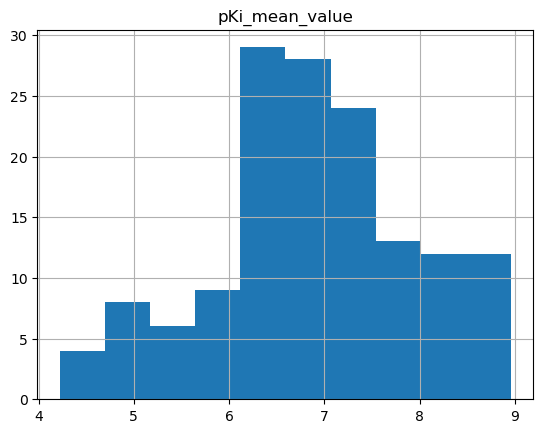

In [44]:
plasmodium_chembl_output_df.hist(column='pKi_mean_value')

array([[<AxesSubplot: title={'center': 'pKi_last_value'}>]], dtype=object)

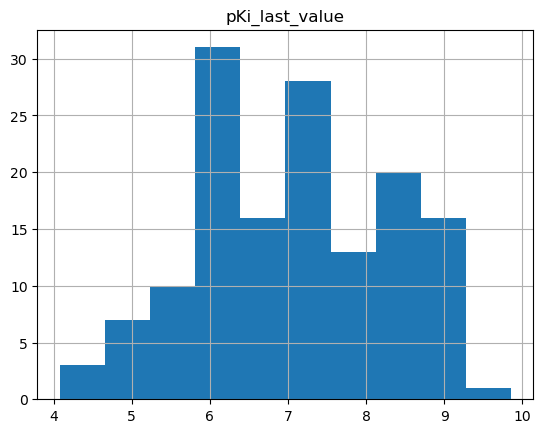

In [45]:
plasmodium_chembl_output_df.hist(column='pKi_last_value')

array([[<AxesSubplot: title={'center': 'pKi_first_value'}>]], dtype=object)

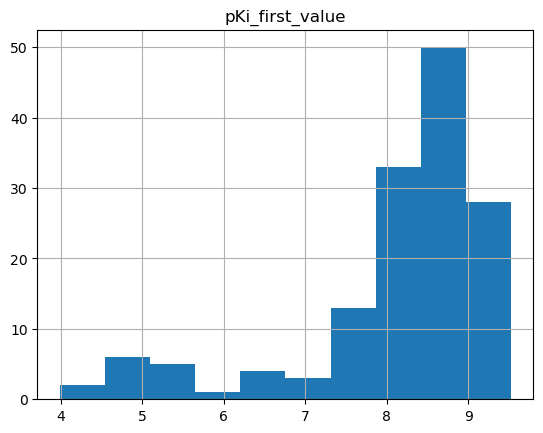

In [46]:
plasmodium_chembl_output_df.hist(column='pKi_first_value')

### Saving the final output (csv)

Furthermore, we need to reorder the columns to finally save it in a '.csv' file:

In [ ]:
plasmodium_chembl_output_final = plasmodium_chembl_output_df[['molecule_chembl_id', 'smiles', 'pKi_mean_value', 'mean_Ki_value', 'pKi_first_value','pKi_last_value', 'last_Ki_value', 'target_organism' ]]
# Final check
plasmodium_chembl_output_final.head(5)

In [ ]:
plasmodium_chembl_output_final.to_csv(DATA/"plasmodium_dhfr_chembl_compounds.csv", index=False)

## Session and packages used on this notebook:

In [ ]:
import session_info
session_info.show()